# Exploring PyDEIMOS

In this notebook, we explore different ingredients that go into the DEIMOS shape measurement method, and see how to optimise its performance.

## Table of contents

<a href="paper_plot">Reproducing plots from the original DEIMOS paper</a>

<a href="gauss_diagnose">Diagnosing simple Gaussian case</a>


In [504]:
## Import the necessary modules
import galsim
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LogNorm
## Import our script
from deimos import *
from helper import *
from moments import *

<a id="paper_plot"></a>

We will now try to reproduce Figure 1 of Melchior et al. (2012)

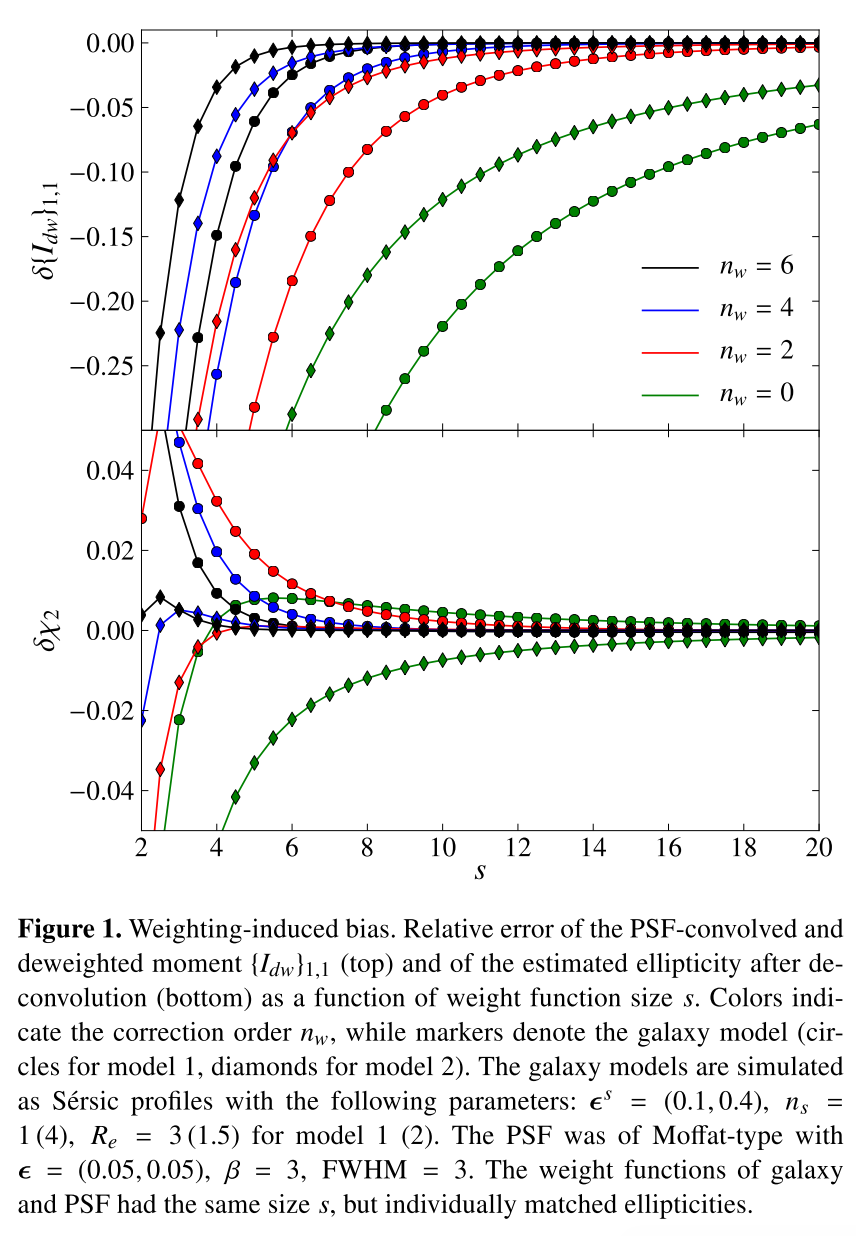

In [489]:
## Construct the PSF and galaxy models
psf = galsim.Moffat(beta=3, fwhm=3).shear(g1=0.05,g2=0.05)
gal1 = galsim.Exponential(half_light_radius=3).shear(g1=0.1,g2=0.4)
gal4 = galsim.DeVaucouleurs(half_light_radius=1.5).shear(g1=0.1,g2=0.4)

## Draw the galaxy and PSF images
scale = 1.
img_psf = psf.drawImage(scale=scale, method='no_pixel')
img1 = galsim.Convolve([gal1,psf]).drawImage(scale=scale, method='no_pixel')
img4 = galsim.Convolve([gal4,psf]).drawImage(scale=scale, method='no_pixel')

hsm1 = img1.FindAdaptiveMom()
hsm4 = img4.FindAdaptiveMom()

In [493]:
## Calling some internal DEIMOS routines
psf_grid = generate_pixelgrid([-0.5,-0.5], img_psf.array.shape, scale=scale)
gal1_grid = generate_pixelgrid([-0.5,-0.5], img1.array.shape, scale=scale)
gal4_grid = generate_pixelgrid([-0.5,-0.5], img4.array.shape, scale=scale)

## Calculate the (1,1) deweighted moment and ellipticity as a function of weight size
S = np.linspace(2,30,29)
lines = ["#s idx nw0 nw2 nw4 nw6\n"]
idx11 = doublet_to_singlet(1,1)
dat1, dat2 = np.zeros((2*len(S), 6)), np.zeros((2*len(S),6))
kmax = (6+3)*(6+4)/2
psf_moments, gal1_moments, gal4_moments = np.zeros(kmax), np.zeros(kmax), np.zeros(kmax)
for sidx, s in enumerate(S):
    weight_psf = get_weight_image(psf_grid, s, 0.05, 0.05)
    weight1 = get_weight_image(gal1_grid, s, hsm1.observed_shape.g1, hsm1.observed_shape.g2)
    weight4 = get_weight_image(gal4_grid, s, hsm4.observed_shape.g1, hsm4.observed_shape.g2)
    for k in xrange(kmax):
        m,n = singlet_to_doublet(k)
        psf_moments[k] = measure_moments(m,n,img_psf,psf_grid,weight=weight_psf)
        gal1_moments[k] = measure_moments(m,n,img1,gal1_grid,weight=weight1)
        gal4_moments[k] = measure_moments(m,n,img4,gal4_grid,weight=weight4)
        
    DW = generate_deweighting_matrix( s, 0.1, 0.4, 6)
    DW_psf = generate_deweighting_matrix( s, 0.05, 0.05, 6)
    
    dat1[2*sidx][0] = s; dat1[2*sidx+1][0] = s
    dat1[2*sidx][1] = 1; dat1[2*sidx+1][1] = 4
    dat2[2*sidx][0] = s; dat2[2*sidx+1][0] = s
    dat2[2*sidx][1] = 1; dat2[2*sidx+1][1] = 4
    
    for nw in [0,2,4,6]:
        kmax = (nw+3)*(nw+4)/2
        deweighted_psf_moments = np.dot(DW_psf[:,:kmax], psf_moments[:kmax])
        deweighted_img1_moments = np.dot(DW[:,:kmax], gal1_moments[:kmax])
        deweighted_img4_moments = np.dot(DW[:,:kmax], gal4_moments[:kmax])
        
        dat1[2*sidx, 2+nw/2] = deweighted_img1_moments[idx11]/deweighted_img1_moments[0]
        dat1[2*sidx+1, 2+nw/2] = deweighted_img4_moments[idx11]/deweighted_img4_moments[0]
        
        psf_corr_moments1 = psf_correction(deweighted_img1_moments, deweighted_psf_moments)
        psf_corr_moments4 = psf_correction(deweighted_img4_moments, deweighted_psf_moments)
        
        dat2[2*sidx, 2+nw/2] = moments_to_ellipticity(psf_corr_moments1,etype='chi')[1]
        dat2[2*sidx+1, 2+nw/2] = moments_to_ellipticity(psf_corr_moments4,etype='chi')[1]
        
unweighted_img1_moment = measure_moments(1,1,img1,gal1_grid,weight=1.)
unweighted_img4_moment = measure_moments(1,1,img4,gal4_grid,weight=1.)

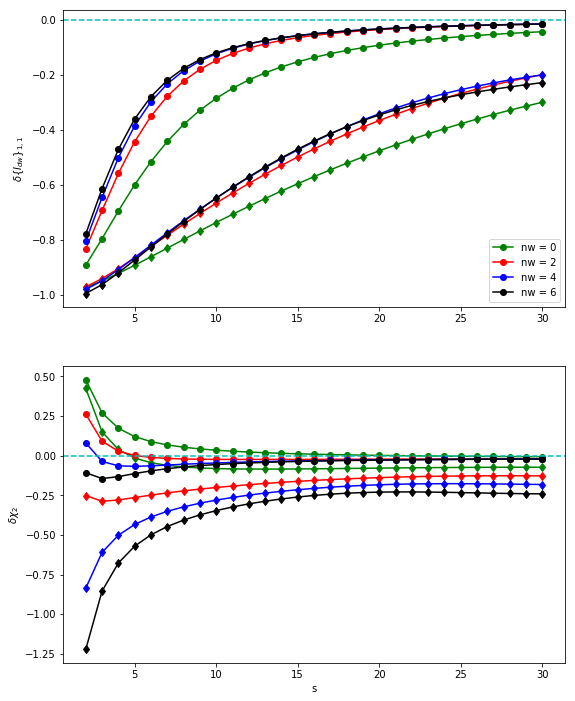

In [494]:
## Plot 
fig, ax = plt.subplots(2)
fig.set_size_inches([9,12])
colors = ['g','r','b','k']
g2 = galsim.Shear(g1=0.1,g2=0.4).e2
for nw in [0,2,4,6]:
    ax[0].plot(S,(dat1[dat1[:,1]==1, 2+nw/2]/unweighted_img1_moment-1),'o-',color=colors[nw/2],label='nw = %d' %(nw))
    ax[0].plot(S,(dat1[dat1[:,1]==4, 2+nw/2]/unweighted_img4_moment-1),'d-',color=colors[nw/2])
    ax[1].plot(S, (dat2[dat2[:,1]==1, 2+nw/2]/g2-1), 'o-', color=colors[nw/2], label='nw = %d' % (nw))
    ax[1].plot(S, (dat2[dat2[:,1]==4, 2+nw/2]/g2-1), 'd-', color=colors[nw/2])
    
ax[1].set_xlabel('s')
ax[0].set_ylabel(r'$\delta\{I_{dw}\}_{1,1}$')
ax[1].set_ylabel(r'$\delta \chi_2$')
ax[0].axhline(0.0,color='c',ls='--')
ax[1].axhline(0.0,color='c',ls='--')
ax[0].legend(loc='best')

Our results do not look like the plot above from the paper. We will do some quick sanity check to ensure that we are doing this correctly. Let's look at one of the galaxy image and its weight function. 

Note, the vertical axis is flipped, and therefore, the sign of e2 will appear flipped.

Text(0,0.5,'$n=4$')

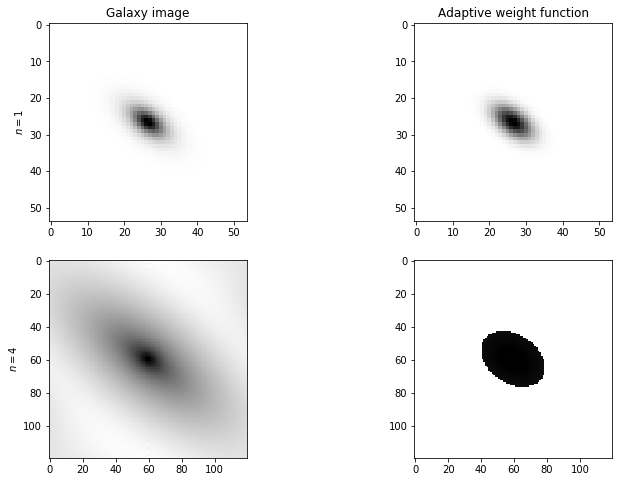

In [513]:
fig, ax = plt.subplots(2,2)
fig.set_size_inches(12,8)
ax[0,0].imshow(img1.array, cmap=cm.gray_r)
ax[0,1].imshow(get_weight_image(gal1_grid,hsm1.moments_sigma*scale,hsm1.observed_shape.g1,hsm1.observed_shape.g2),cmap=cm.gray_r)
ax[1,0].imshow(img4.array, cmap=cm.gray_r, norm=LogNorm())
ax[1,1].imshow(get_weight_image(gal4_grid,hsm4.moments_sigma*scale,hsm4.observed_shape.g1,hsm4.observed_shape.g2),cmap=cm.gray_r, norm=LogNorm())
ax[0,0].set_title('Galaxy image'); ax[0,1].set_title('Adaptive weight function')
ax[0,0].set_ylabel(r'$n=1$'); ax[1,0].set_ylabel(r'$n=4$')

## Diagnosing simple Gaussian case

Let's start by analysing the case of a simple elliptical Gaussian, where analytical calculations are possible if needed.

In [587]:
gauss_shape = galsim.Shear(e1=0.6, e2=0.6)
gauss = galsim.Gaussian(sigma=3.7).shear(gauss_shape)
gscale = 1.
gauss_img = gauss.drawImage(scale=gscale, method='no_pixel')
hsm = gauss_img.FindAdaptiveMom()

gauss_grid = generate_pixelgrid([-0.5,-0.5],gauss_img.array.shape,scale=gscale)
weight_img = get_weight_image(gauss_grid, hsm.moments_sigma*gscale, hsm.observed_shape.g1, hsm.observed_shape.g2)

nw = 6
unweighted_moments = np.zeros(6)
weighted_moments = np.zeros((nw+3)*(nw+4)/2)
for k in xrange((nw+3)*(nw+4)/2):
    i,j = singlet_to_doublet(k)
    if k<6:
        unweighted_moments[k] = measure_moments(i,j,gauss_img.array, gauss_grid,weight=1.)
    weighted_moments[k] = measure_moments(i,j,gauss_img.array, gauss_grid, weight=weight_img)
    
DW = generate_deweighting_matrix(hsm.moments_sigma*gscale, hsm.observed_shape.g1, hsm.observed_shape.g2, nw=nw)
dDW = DW - np.eye(6,DW.shape[1])
deweighted_moments = np.dot(DW, weighted_moments)

Let's ensure that the Gaussian looks okay

Text(0.5,1,'Adaptive weight function')

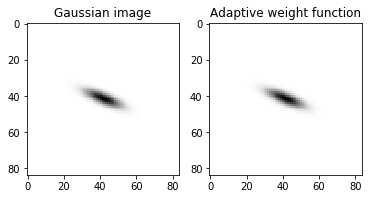

In [588]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(gauss_img.array, cmap=cm.gray_r)
ax[1].imshow(weight_img, cmap=cm.gray_r)
ax[0].set_title('Gaussian image'); ax[1].set_title('Adaptive weight function')

Do we recover the input quantities from weighted moments?

In [589]:
print "Input ellipticity = ", gauss_shape
print "Recovered ellipticity = ", moments_to_ellipticity(deweighted_moments)
print "Input sigma = ", gauss.original.sigma, "or", hsm.moments_sigma
print "Measured sigma = ", moments_to_size(deweighted_moments, size_type='det',flux_normalized=True)

Input ellipticity =  galsim.Shear(g1=0.392374781489,g2=0.392374781489)
Recovered ellipticity =  (0.3923747896206745, 0.3923747898030053)
Input sigma =  3.7 or 3.70000004768
Measured sigma =  3.1731251645949703


While we are able to recover the ellipticity very well from the deweighted moments, the sizes don't agree indicating that the deweighted moments don't quite match the unweighted moments. We now compare them directly.

In [590]:
print "Unweighted moments = ", np.round(unweighted_moments,10)
print "Deweighted moments = ", np.round(deweighted_moments,10)
print "Ratio of second order deweighted moments to corresponding unweighted moments = \n",((deweighted_moments[3:]/unweighted_moments[3:])/deweighted_moments[0])**0.5

Unweighted moments =  [ 1.00000001  0.         -0.         10.3486673  15.52300091 41.39466906]
Deweighted moments =  [ 0.75361196 -0.         -0.          5.73592113  8.60388194 22.943685  ]
Ratio of second order deweighted moments to corresponding unweighted moments = 
[0.8576014  0.85760141 0.85760141]


It appears that all the deweighted second order moments fall short of their true values by the same ratio, which leaves the ellipticity unaffected but affects the size calculation. This ratio is exactly the ratio between Measured sigma and Input sigma.

Let us now visualise the deweighting matrix. We will discard the unity entries along the diagonal to improve contrast.

array([10.,  6.])

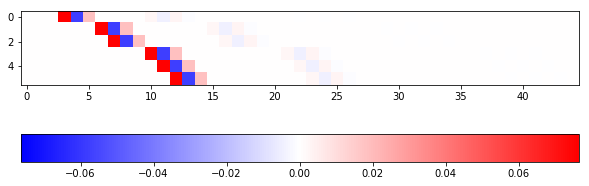

In [591]:
## Visualize the deweighting matrix
fig, ax = plt.subplots()
fig.set_size_inches(10,6)
vmax = max(dDW.max(),-dDW.min())
_im = ax.imshow(dDW, cmap=cm.bwr, vmin=-vmax, vmax=vmax)
_cbar = fig.colorbar(_im,ax=ax,orientation='horizontal')
fig.get_size_inches()

The elements in the deweighting matrix corresponding to the higher order moments are small. This is expected as the Taylor expansion of inverse Gaussian is a convergent series. However, we need to ensure that the correction terms with the higher order moments converge quick enough.

We now visualise the correction terms to the deweighted moments (0,2), (1,1) and (2,0), which go into the calculation of shear. We have inverted the sign of correction terms to (0,2) since they influence e1 in opposite direction wrt (2,0).

The first group corresponds to the weighted second moments themselves. The successive groups correspond to nw = 2, 4, 6.

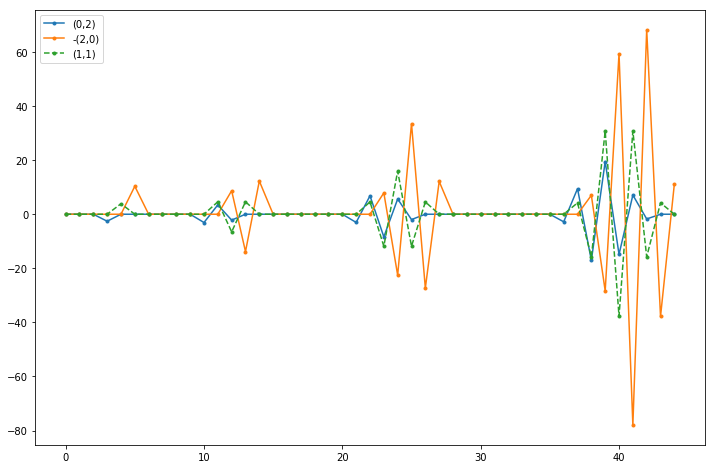

In [592]:
fig, ax = plt.subplots()
fig.set_size_inches(12,8)
ax.plot(-(DW[3,:]*weighted_moments),'.-',label='(0,2)')
ax.plot(DW[5,:]*weighted_moments,'.-',label='-(2,0)')
ax.plot(DW[4,:]*weighted_moments,'.--',label='(1,1)')
ax.legend(loc='best')

In [485]:
print moments_to_ellipticity(weighted_moments), hsm.observed_shape
print moments_to_ellipticity(deweighted_moments, etype='chi')
print moments_to_size(weighted_moments,size_type='det',flux_normalized=True)/hsm.moments_sigma
print moments_to_size(deweighted_moments,size_type='det',flux_normalized=True)/hsm.moments_sigma
print moments_to_size(unweighted_moments,size_type='det',flux_normalized=True)/hsm.moments_sigma
print galsim.Image(weight_img).FindAdaptiveMom().moments_sigma

(1.498822864055422e-16, 0.4083673639789859) galsim.Shear(g1=2.99764543114e-16,g2=0.408367357613)
(0.0, 0.6999999978305085)
0.707106786264932
0.8603181883677607
1.0000000128874738
3.14249062538
